In [1]:
import sys
import os

current_dir = os.getcwd()

project_root = os.path.abspath(os.path.join(os.path.dirname(current_dir + '/pinns'), '..'))
if project_root not in sys.path:
    sys.path.append(project_root)

import pinns

# For cleaner output.
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

Here we solve time-dependent PDE problem with one spatial dimension and Dirichlet boundary conditions.

Given domain $[0, T] \times [A, B]$, and functions $f(x)$, $g_1(t)$, $g_2(t)$, find such $u(t, x)$ so that

$$\frac{\partial u}{\partial t} = D \frac{\partial^2 u}{\partial x^2}$$
$$u(0, x) = f(x), \quad u(t, A) = g_1(t), \quad u(t, B) = g_2(t)$$

Usually we get boundary conditions as functions, but one of the main features of machine learning is the ability to represent some function using finite training dataset. Let's assume that boundary values are given as finite collection of measurements.

In [2]:
import torch
import torch.nn as nn

import matplotlib.pyplot as plt

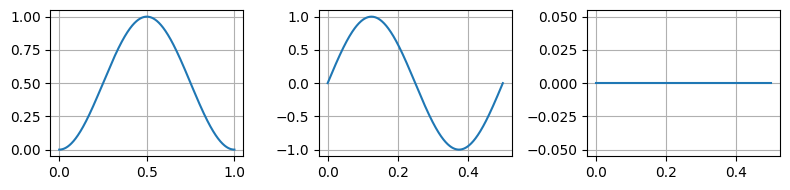

In [3]:
def f(x):
    return torch.sin(torch.pi * x) ** 2
    
def g_1(t):
    return torch.sin(4 * torch.pi * t)

def g_2(t):
    return 0 * t

A, B, T = 0, 1, 0.5
D = 0.5

Nt, Nx = 500, 750
t = torch.linspace(0, T, Nt)
x = torch.linspace(A, B, Nx)

initial_values = f(x)
left_boundary = g_1(t)
right_boundary = g_2(t)

fig, axs = plt.subplots(1, 3, figsize=(8, 2))
axs[0].plot(x, initial_values)
axs[1].plot(t, left_boundary)
axs[2].plot(t, right_boundary)

for i in range(3): axs[i].grid()
plt.tight_layout()
plt.show()

Now let's solve this problem numerically using Crank-Nicholson scheme.

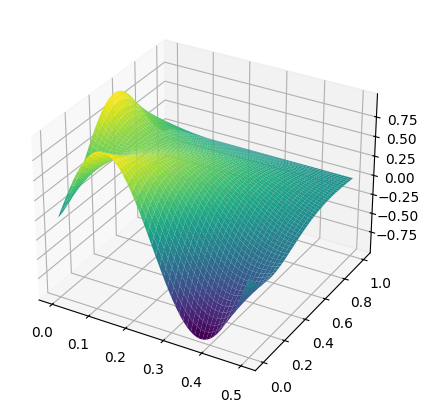

In [4]:
dx = (B - A) / Nx
dt = T / Nt
alpha = D * dt / (2 * dx ** 2)

u = torch.zeros((Nt, Nx))

u[0, :] = initial_values
u[:, 0], u[:, -1] = left_boundary, right_boundary

A_cs = torch.diag((1 + 2*alpha) * torch.ones(Nx)) + torch.diag(-alpha * torch.ones(Nx-1), 1) + torch.diag(-alpha * torch.ones(Nx-1), -1)
B_cs = torch.diag((1 - 2*alpha) * torch.ones(Nx)) + torch.diag(alpha * torch.ones(Nx-1), 1) + torch.diag(alpha * torch.ones(Nx-1), -1)
    
A_reversed = torch.linalg.inv(A_cs)

for n in range(0, Nt - 1):

    b = B_cs @ (u[n, :])
    b[0] = alpha * left_boundary[n]
    b[-1] = alpha * right_boundary[n]

    u[n+1, :] = A_reversed @ b
    
t_pts, x_pts = torch.meshgrid(t, x)

fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(t_pts, x_pts, u, cmap='viridis')
plt.show()

In [5]:
import numpy as np 

# For further purposes, we save our data tensors.
# At first we translate them to form [num_pts x [t, x, u]].

init = torch.vstack([torch.zeros_like(x), x, initial_values]).T
left = torch.vstack([t, torch.ones_like(t) * A, left_boundary]).T
right= torch.vstack([t, torch.ones_like(t) * B, right_boundary]).T
solution = torch.stack([t_pts.flatten(), x_pts.flatten(), u.flatten()]).T

np.save('./data/diffusion/init.npy', init)
np.save('./data/diffusion/left.npy', left)
np.save('./data/diffusion/right.npy', right)
np.save('./data/diffusion/u.npy', solution)

init.shape, left.shape, right.shape, solution.shape

(torch.Size([750, 3]),
 torch.Size([500, 3]),
 torch.Size([500, 3]),
 torch.Size([375000, 3]))

Let's write our samplers. Since we assume that given boundary conditions are of finite size, let's explore two cases.

Case 1: they are stored in memory in full length.

Case 2: they are stored on disk and are very large, so we will randomly sample subsets from it as batches.

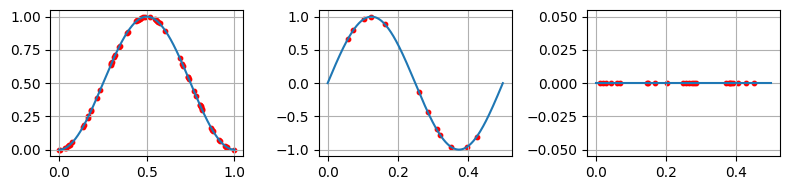

In [6]:
import numpy as np

# Fix data size
N_I, N_A, N_B = 64, 12, 24

# Let's get some random subset from functions.
init_pts = torch.rand((N_I)).sort().values * (B - A) + A
left_pts = torch.rand((N_A)).sort().values * T
right_pts = torch.rand((N_B)).sort().values * T

init_data = f(init_pts)
left_data = g_1(left_pts)
right_data = g_2(right_pts)

# Plot generated values.

fig, axs = plt.subplots(1, 3, figsize=(8, 2))

axs[0].plot(x, initial_values)
axs[1].plot(t, left_boundary)
axs[2].plot(t, right_boundary)

axs[0].scatter(init_pts, init_data, color='r', s=10)
axs[1].scatter(left_pts, left_data, color='r', s=10)
axs[2].scatter(right_pts, right_data, color='r', s=10)

for i in range(3): axs[i].grid()
plt.tight_layout()
plt.show()

---

In [7]:
from pinns.samplers import RandomSampler, RandomDictSampler, ConstantSampler

Constraints sampler.

In [8]:
# Case 1
class BoundarySampler:
    def __init__(self, path, num_pts):
        self.path = path
        self.N_I, self.N_A, self.N_B = num_pts
        
    def __call__(self):
        init = np.load(self.path + 'init.npy', mmap_mode='r')
        left = np.load(self.path + 'left.npy', mmap_mode='r')
        right = np.load(self.path + 'right.npy', mmap_mode='r')
    
        init_idx = np.random.choice(init.shape[0], self.N_I)
        left_idx = np.random.choice(left.shape[0], self.N_A)
        right_idx = np.random.choice(right.shape[0], self.N_B)
        
        init_sampled = torch.tensor(init[init_idx])
        left_sampled = torch.tensor(left[left_idx])
        right_sampled = torch.tensor(right[right_idx])
        
        return ([init_sampled[:,:2], left_sampled[:,:2], right_sampled[:,:2]],
                [init_sampled[:, 2], left_sampled[:, 2], right_sampled[:, 2]])
        
# constraints_sampler = BoundarySampler('./data/diffusion/', (512, 256, 256))

# Case 2
points = [
    torch.vstack([torch.zeros_like(init_pts), init_pts]).T,
    torch.vstack([left_pts, torch.ones_like(left_pts) * A]).T,
    torch.vstack([right_pts, torch.ones_like(right_pts) * B]).T,
]

targets = [
    init_data.reshape(-1, 1), 
    left_data.reshape(-1, 1), 
    right_data.reshape(-1, 1)
]

constraints_sampler = ConstantSampler((points, targets))

Collocation sampler.

In [9]:
# If we use this sampler, we must edit our loss function
# so that it takes not t and x separately, but z instead
# of shape [1024, 2]. Then we must calculate gradient
# and use slices to take grad of specific tensors, for
# example: ut = d(u, z)[:, 0]. But it is very ugly.

# domain = [torch.tensor([0., A]),
#           torch.tensor([T,  B])]
# collocation_sampler = RandomSampler(domain, (1024, 2))

# We will instead use much clearer RandomDictSampler.

collocation_sampler = RandomDictSampler({'t': [0, T], 'x': [A, B]}, 2048)

Data Sampler. We do not want to load all test points every time, so let's write sampler that gives us either all data points or random subset of them.

In [10]:
class DataSampler:
    def __init__(self, path, num_pts):
        self.path = path
        self.N_F = num_pts
        
    def __call__(self, full = False):
        test_data = np.load(self.path + 'u.npy', mmap_mode='r')
        
        if full:
            return (torch.tensor(test_data[:,:2]), 
                    torch.tensor(test_data[:, 2].reshape(-1, 1)))
        
        idx = np.random.choice(test_data.shape[0], self.N_F)
        sampled = torch.tensor(test_data[idx])
            
        return (sampled[:, :2], sampled[:, 2].reshape(-1, 1))

# 1024 is pretty much enough.
test_data_sampler = DataSampler('./data/diffusion/', 1024)

Now it's time to write loss function. Remember: we should return tuple of losses, so if you want, for example, multiply loss along each boundary, or multiply sum of boundary losses - you should just be sure that number of returned elements and number of loss coefficients are the same.

In [11]:
from pinns.derivatives import d

def loss(
    cstr_pts, cstr_pred, cstr_vals,
    coll_pts, coll_pred,
    D = 0.5
    ):
    
    # We do not need left and right because we are solving 
    # Dirichlet problem and we just compare predictions and 
    # solution. If we solve Cauchy or Robin problem, we 
    # need to calculate derivatives at boundary points.
    
    init_pts, left_pts, right_pts = cstr_pts
    init_pred, left_pred, right_pred = cstr_pred
    init_vals, left_vals, right_vals = cstr_vals
    
    # If we use RandomSampler, we are unable to split values
    # like that. But it is just for clarity.
    
    t, x = coll_pts['t'], coll_pts['x']
    
    def initial_loss():
        return torch.mean(torch.square(init_pred - init_vals))
    
    def left_loss():
        return torch.mean(torch.square(left_pred - left_vals))
    
    def right_loss():
        return torch.mean(torch.square(right_pred - right_vals))
    
    def pde_loss(u, t, x):
        ut  = d(u,  t)
        ux  = d(u,  x)
        uxx = d(ux, x)
        
        return torch.mean(torch.square(ut - D * uxx))
    
    return (
        initial_loss(), 
        left_loss(), 
        right_loss(), 
        pde_loss(coll_pred, t, x)
    )

In [12]:
from pinns import Trainer
from pinns.models import FF
from pinns.optimizers import Adam, LBFGS

pinn = FF([2, 32, 32, 1], activ=nn.Tanh())

adam = Adam(pinn, lr = 1e-2)
lbfgs = LBFGS(pinn, lr = 5e-3)

trainer = Trainer(
    loss,
    pinn,
    constraints_sampler,
    collocation_sampler,
    loss_coefs = [0.75]*3 + [0.25],
    test_points_sampler = test_data_sampler
)

trainer.train(
    num_iters=2500,
    optimizers=[(0, adam), (2250, lbfgs)],
    validate_every=1
    )

  0%|          | 0/2500 [00:00<?, ?it/s]

In [13]:
from pinns.errors import l2_error, rmse_error

# If we are using L2 error, we need to be aware that
# if number of points increases, then error will be
# too. Because of that, we might prefer RMSE metric.
trainer.evaluate(rmse_error, full = True)

0.06470823

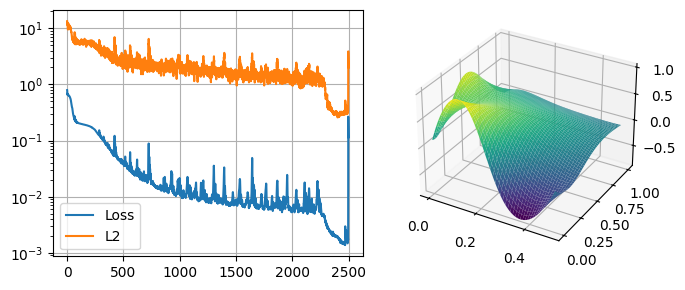

In [14]:
fig = plt.figure(figsize=(7, 3))

ax = fig.add_subplot(121)
ax.plot(trainer.loss_history, label='Loss')
ax.plot(range(0, trainer.iter + 1, 1), trainer.error_history, label='L2')
ax.grid()
ax.set_yscale('log')
ax.legend()

t_pts, x_pts = torch.meshgrid(t, x)
preds = pinn.predict(test_data_sampler(full=True)[0]).reshape(u.shape).detach()

ax = fig.add_subplot(122, projection='3d')
ax.plot_surface(t_pts, x_pts, preds, cmap='viridis')

plt.tight_layout()
plt.show()